#Given a 30 million dollar budget what genre movie should I make to gross the highest domestic profit?

In [62]:
%matplotlib inline
import pickle
from pprint import pprint
import pandas as pd
import numpy as np

###Load the movie dictionary

In [2]:
d = pickle.load(open('movie_dictionary.p'))

In [397]:
#Create a dataframe 
df = pd.DataFrame.from_dict(d, orient = 'index')

In [398]:
df.dtypes

gross          object
rating         object
distributor    object
budget         object
producers      object
genre          object
directors      object
writers        object
actors         object
date           object
runtime        object
dtype: object

###Clean the data and remove N/A's
Keep only movies with a positive runtime

In [399]:
df2 = df.copy()
df2 = df2[['gross', 'date', 'budget', 'genre', 'runtime']]
df2['gross'][df2.gross == 'N/A'] = np.nan
df2['budget'][df2.budget == 'N/A'] = np.nan
df2['date'][df2.date == 'N/A'] = np.nan
df2['genre'][df2.genre == 'N/A'] = np.nan
df2['genre'][df2.genre == 'Unknown'] = np.nan
df2['runtime'][df2.runtime == 'N/A'] = np.nan
df2 = df2[df2.runtime >= 0]
df2 = df2[df2.budget <= 30]
df2 = df2.dropna()

For budget and gross, if data is missing, populate them with the mean of all the movies

In [400]:
#df2['budget'][df2['budget'].isnull()] = df2['budget'].mean()
#df2['gross'][df2['gross'].isnull()] = df2['gross'].mean()
df2['date'] = pd.to_datetime(df2['date'])
df2['year'] = df2['date'].apply(lambda x: x.year)
df2['gross'] = df2['gross'].astype(int)
df2['budget'] = df2['budget'].astype(int)
df2['runtime'] = df2['runtime'].astype(int)
df2['genre'] = df2['genre'].astype(str)


###Create some log columns

In [361]:
df2['log_runtime'] = df2['runtime'].apply(lambda x: np.log(x))
df2['log_budget'] = df2['budget'].apply(lambda x: np.log(x))
df2['log_gross'] = df2['gross'].apply(lambda x: np.log(x))

###Check top grossing genres

In [365]:
df2.groupby('genre')[['gross', 'budget']].mean().sort('gross', ascending = False)

,gross,budget
genre,,
Sci-Fi Fantasy,3.757365e+08,14.500000
Sci-Fi,9.002770e+07,20.666667
Sci-Fi Adventure,8.438868e+07,18.500000
Period Adventure,7.400013e+07,19.833333
Sci-Fi Horror,6.368889e+07,18.100000
Family Comedy,6.230970e+07,19.800000
Historical Drama,6.202070e+07,19.111111
Horror Comedy,5.876435e+07,20.692308
War,5.469365e+07,18.166667


###Create categories for top unique grossing genres

In [406]:
df2['Comedy'] = df2['genre'].apply(lambda x: 'C' if 'Comedy' in x else '')
df2['Drama'] = df2['genre'].apply(lambda x: 'D' if 'Drama' in x else '')
df2['Horror'] = df2['genre'].apply(lambda x: 'H' if 'Horror' in x else '')
df2['Romance'] = df2['genre'].apply(lambda x: 'R' if ('Romance' in x) or ('Romantic' in x) else '')
df2['Thriller'] = df2['genre'].apply(lambda x: 'T' if 'Thriller' in x else '')
df2['Sci_Fi'] = df2['genre'].apply(lambda x: 'S' if 'Sci-Fi' in x else '')
df2['Music'] = df2['genre'].apply(lambda x: 'M' if 'Music' in x else '')
df2['Action'] = df2['genre'].apply(lambda x: 'A' if 'Action' in x else '')
df2['Adventure'] = df2['genre'].apply(lambda x: 'Ad' if 'Adventure' in x else '')
df2['Historical'] = df2['genre'].apply(lambda x: 'Hi' if 'Historical' in x else '')
df2['Family'] = df2['genre'].apply(lambda x: 'F' if 'Family' in x else '')
df2['War'] = df2['genre'].apply(lambda x: 'W' if 'War' in x else '')
df2['Sports'] = df2['genre'].apply(lambda x: 'S' if 'Sports' in x else '')
df2['Crime'] = df2['genre'].apply(lambda x: 'Cr' if 'Crime' in x else '')
df2['Animation'] = df2['genre'].apply(lambda x: 'An' if 'Animation' in x else '')


###Create a new column for genres that concatenates all the individual columns

In [368]:
df2['genre'] = df2['Comedy'] + df2['Horror'] + df2['Drama'] + df2['Thriller'] + df2['Romance'] + df2['Sci_Fi'] + df2['Music'] + df2['Action'] + df2['Adventure']

In [416]:
columns = ['gross', 'budget']
#Check for no repeats
df_comedy = df2.copy()[df2['Comedy'] == 'C'][columns]
df_comedy['genre'] = 'Comedy'

df_drama = df2.copy()[df2['Drama'] == 'D'][columns]
df_drama['genre'] = 'Drama'

df_horror = df2.copy()[df2['Horror'] == 'H'][columns]
df_horror['genre'] = 'Horror'

df_romance = df2.copy()[df2['Romance'] == 'R'][columns]
df_romance['genre'] = 'Romance'

df_thriller = df2.copy()[df2['Thriller'] == 'T'][columns]
df_thriller['genre'] = 'Thriller'

df_scifi = df2.copy()[df2['Sci_Fi'] == 'S'][columns]
df_scifi['genre'] = 'Sci_Fi'

df_music = df2.copy()[df2['Music'] == 'M'][columns]
df_music['genre'] = 'Music'

df_action = df2.copy()[df2['Action'] == 'Ac'][columns]
df_action['genre'] = 'Action'

df_adventure = df2.copy()[df2['Adventure'] == 'Ad'][columns]
df_adventure['genre'] = 'Adventure'

df_historical = df2.copy()[df2['Historical'] == 'Hi'][columns]
df_historical['genre'] = 'Historical'

df_family = df2.copy()[df2['Family'] == 'F'][columns]
df_family['genre'] = 'Family'

df_war = df2.copy()[df2['War'] == 'W'][columns]
df_war['genre'] = 'War'

df_sports = df2.copy()[df2['Sports'] == 'S'][columns]
df_sports['genre'] = 'Sports'

df_crime = df2.copy()[df2['Crime'] == 'Cr'][columns]
df_crime['genre'] = 'Crime'

df_animation = df2.copy()[df2['Animation'] == 'An'][columns]
df_animation['genre'] = 'Animation'





In [419]:
final_df = df_comedy.copy()
final_df = final_df.append(df_drama)
final_df = final_df.append(df_horror)
final_df = final_df.append(df_romance)
final_df = final_df.append(df_thriller)
final_df = final_df.append(df_scifi)
final_df = final_df.append(df_music)
final_df = final_df.append(df_action)
final_df = final_df.append(df_adventure)
final_df = final_df.append(df_historical)
final_df = final_df.append(df_family)
final_df = final_df.append(df_war)
final_df = final_df.append(df_sports)
final_df = final_df.append(df_crime)
final_df = final_df.append(df_animation)
final_df


,gross,budget,genre
10 Things I Hate About You (1999),38178166,30,Comedy
200 Cigarettes (1999),6852450,6,Comedy
21 and Over (2013),25682380,13,Comedy
27 Dresses (2008),76808654,30,Comedy
30 Minutes or Less (2011),37053924,28,Comedy
50/50 (2011),35014192,8,Comedy
A Cinderella Story (2004),51438175,19,Comedy
A Guy Thing (2003),15545431,20,Comedy
A Haunted House 2 (2014),17329486,4,Comedy
A Lot Like Love (2005),21845719,30,Comedy


In [427]:
final_df.groupby('genre').mean().sort('gross', ascending = False)

,gross,budget
genre,,
Sci_Fi,58826565.093023,18.674419
Historical,55834743.000000,17.000000
War,47318138.727273,17.272727
Animation,47227949.289474,20.552632
Family,46926128.568182,19.409091
Sports,46346035.527778,20.388889
Horror,42254671.856115,16.726619
Adventure,42070484.944444,18.083333
Romance,40687603.771930,18.570175


genre
Adventure     [Axes(0.125,0.125;0.775x0.775)]
Animation     [Axes(0.125,0.125;0.775x0.775)]
Comedy        [Axes(0.125,0.125;0.775x0.775)]
Crime         [Axes(0.125,0.125;0.775x0.775)]
Drama         [Axes(0.125,0.125;0.775x0.775)]
Family        [Axes(0.125,0.125;0.775x0.775)]
Historical    [Axes(0.125,0.125;0.775x0.775)]
Horror        [Axes(0.125,0.125;0.775x0.775)]
Music         [Axes(0.125,0.125;0.775x0.775)]
Romance       [Axes(0.125,0.125;0.775x0.775)]
Sci_Fi        [Axes(0.125,0.125;0.775x0.775)]
Sports        [Axes(0.125,0.125;0.775x0.775)]
Thriller      [Axes(0.125,0.125;0.775x0.775)]
War           [Axes(0.125,0.125;0.775x0.775)]
dtype: object

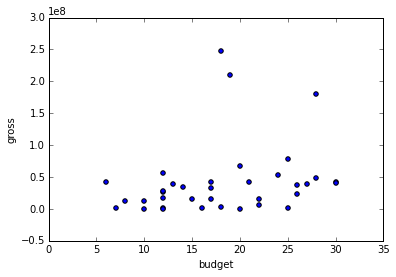

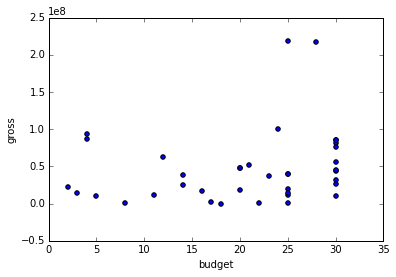

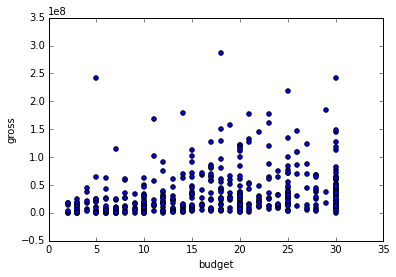

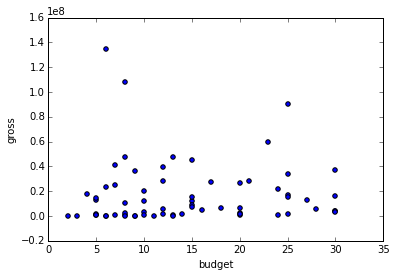

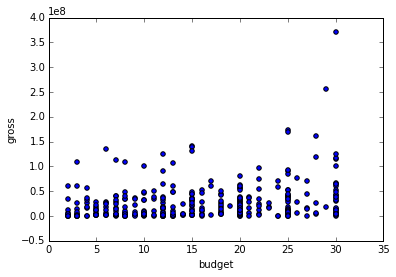

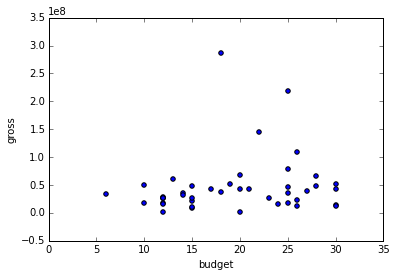

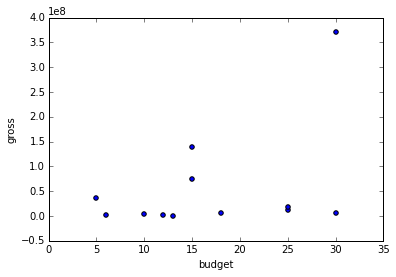

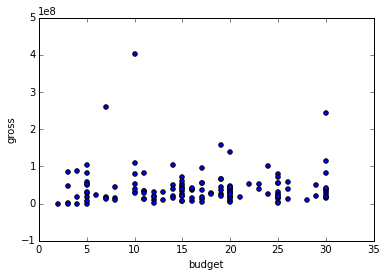

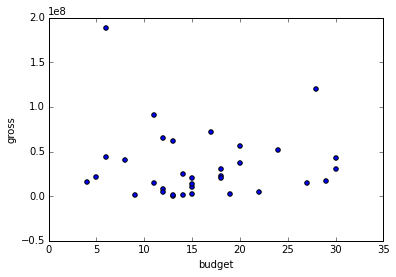

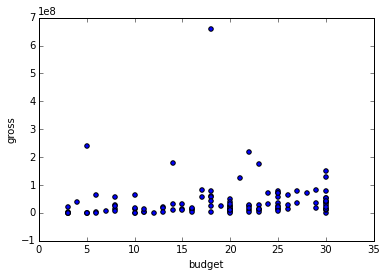

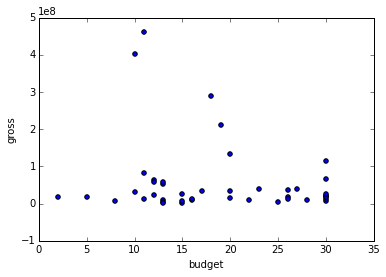

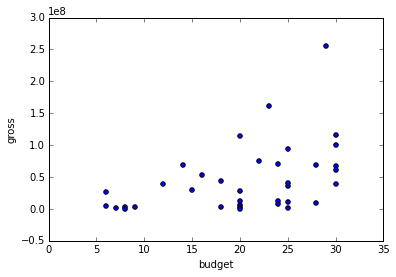

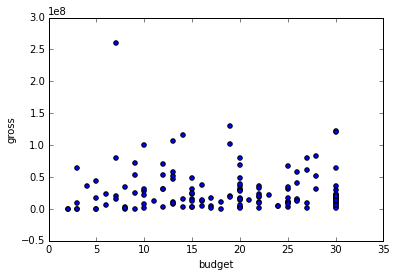

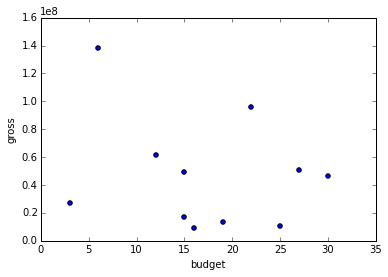

In [435]:
final_df.sort('budget', ascending = True).groupby('genre').plot(x = 'budget', y = 'gross', kind = 'scatter', subplots = True)

###Linear Regression

In [440]:
from patsy import dmatrices
from patsy import dmatrix
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

In [547]:
plot_data = final_df[final_df["genre"] == "Adventure"].sort('budget', ascending = True)

y, X = dmatrices('gross ~ budget', data = plot_data, return_type = 'dataframe')


In [539]:
#SK Learn
model = LinearRegression()
fitted = model.fit(X,y)
model.score(X,y)



0.080912441839175564

In [549]:
#Patsy
model = sm.OLS(y,X)
fitted = model.fit()
fitted.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  gross   R-squared:                       0.063
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     2.288
Date:                Tue, 06 Oct 2015   Prob (F-statistic):              0.140
Time:                        19:24:21   Log-Likelihood:                -692.12
No. Observations:                  36   AIC:                             1388.
Df Residuals:                      34   BIC:                             1391.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   4.543e+06   2.65e+07      0.172      0.865     -4.93e+07  5.84e+07
budget      2.075e+06   1.37e+06      1.513      0.140     -7.13e+05  4.86e+06
==============================================================================
Omnibus:                       36.671   Durbin-Watson:                   2.283
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               93.411
Skew:                           2.520   Prob(JB):                     5.20e-21
Kurtosis:                       9.072   Cond. No.                         55.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

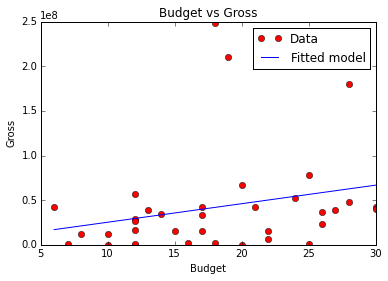

In [550]:
import matplotlib.pyplot as plt

#plt.plot(X, plot_data['gross'], 'ro')
#plt.plot(X, fitted.fittedvalues, 'b')

plt.plot(plot_data['budget'], plot_data['gross'], 'ro')
plt.plot(plot_data['budget'], fitted.fittedvalues, 'b')
plt.legend(['Data', 'Fitted model'])
plt.xlabel('Budget')
plt.ylabel('Gross')
plt.title('Budget vs Gross')